In [1]:

import torch; torch.manual_seed(0) #set for reproducibility!
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import time
from datetime import datetime, timedelta
import os

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

# augmentation_name = 'rotation_v2'
augmentation_name = 'rotation_zoom'

# ====== Load the Trained Classifier ======
print("Loading trained classifier...")

# Import the classifier model class
from mnist_classifier_model import AugmentedMNISTClassifier

# Load the trained classifier
classifier = AugmentedMNISTClassifier(num_classes=10).to(device)
classifier_path = f'../models/{augmentation_name}_augmented_mnist_classifier.pth'
classifier.load_state_dict(torch.load(classifier_path, map_location=device))
classifier.eval()
print(f"Classifier loaded from: {classifier_path}")

# Load classifier info to verify
classifier_info_path = '../models/rotated_mnist_classifier_info.pth'
if os.path.exists(classifier_info_path):
    classifier_info = torch.load(classifier_info_path, map_location=device)
    print(f"Classifier achieved {classifier_info['final_val_acc']:.2f}% validation accuracy")

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load augmented data
train_images = np.load(f'../data/augmented/{augmentation_name}_augmented_mnist_train_images.npy')
train_labels = np.load(f'../data/augmented/{augmentation_name}_augmented_mnist_train_labels.npy')
test_images = np.load(f'../data/augmented/{augmentation_name}_augmented_mnist_test_images.npy')
test_labels = np.load(f'../data/augmented/{augmentation_name}_augmented_mnist_test_labels.npy')

# Convert to torch tensors
train_images = torch.from_numpy(train_images).unsqueeze(1).float()  # shape: (N, 1, 28, 28)
train_labels = torch.from_numpy(train_labels).long()
test_images = torch.from_numpy(test_images).unsqueeze(1).float()
test_labels = torch.from_numpy(test_labels).long()

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


mps
Loading trained classifier...
Classifier loaded from: ../models/rotation_zoom_augmented_mnist_classifier.pth
Classifier achieved 97.34% validation accuracy


In [2]:

# ====== CNN VAE ======
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # (B,32,14,14)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # (B,64,7,7)
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 64*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # (B,32,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # (B,1,28,28)
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 64, 7, 7)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        # KL divergence
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return x_hat, kl

# ====== Training loop for ConvVAE ======
num_epochs = 20
latent_dims = 32
beta = 0.5

train_conv_vae = False
if train_conv_vae:
    conv_vae = ConvVAE(latent_dims).to(device)
    opt = torch.optim.Adam(conv_vae.parameters())

    # Timing setup
    start_time = time.time()
    epoch_times = []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        for x, y in train_loader:
            x = x.to(device)
            opt.zero_grad()
            x_hat, kl = conv_vae(x)
            loss = ((x - x_hat)**2).sum() + beta * kl
            loss.backward()
            opt.step()

        # Calculate timing
        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)
        total_time = time.time() - start_time

        # Estimate remaining time
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        remaining_epochs = num_epochs - (epoch + 1)
        estimated_remaining = avg_epoch_time * remaining_epochs

        # Format time strings
        elapsed_str = str(timedelta(seconds=int(total_time)))
        remaining_str = str(timedelta(seconds=int(estimated_remaining)))

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
              f'Time: {epoch_time:.1f}s, Elapsed: {elapsed_str}, ETA: {remaining_str}')

    print(f"\nTraining completed in {str(timedelta(seconds=int(time.time() - start_time)))}")
    print(f"Average epoch time: {sum(epoch_times)/len(epoch_times):.1f} seconds")

    # ====== Show 4 examples and their reconstructions ======
    examples, labels = next(iter(test_loader))
    examples = examples[:4].to(device)  # Take exactly 4 examples
    with torch.no_grad():
        reconstructions, _ = conv_vae(examples)
    examples = examples.cpu().numpy()
    reconstructions = reconstructions.cpu().numpy()
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i in range(4):
        axes[0, i].imshow(examples[i][0], cmap='gray')
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructions[i][0], cmap='gray')
        axes[1, i].set_title(f"Reconstruction {i+1}")
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

    ### Visualize latent space with t-SNE
    from sklearn.manifold import TSNE

    print("Computing latent representations for entire test set...")
    all_z = []
    all_labels = []

    conv_vae.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            mu, logvar = conv_vae.encode(data)
            z = conv_vae.reparameterize(mu, logvar)
            all_z.append(z.cpu().numpy())
            all_labels.append(labels.numpy())
            if batch_idx % 10 == 0:
                print(f"Processed batch {batch_idx}/{len(test_loader)}")

    all_z = np.concatenate(all_z, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    print("Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
    z_2d = tsne.fit_transform(all_z)

    plt.figure(figsize=(10, 8))
    plt.scatter(z_2d[:, 0], z_2d[:, 1], c=all_labels, cmap='tab10', s=10, alpha=0.6)
    plt.colorbar(label='Digit')
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title(f"t-SNE of ConvVAE Latent Space - {len(all_z)} Test Samples")
    plt.show()


### Conditional VAE

beta=0.75
num_epochs=30
latent_dims=32

def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

class ConditionalConvVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder (same as ConvVAE)
        self.enc = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),   # (B,64,28,28) - use 3x3 kernel with padding=1
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, 1),  # (B,128,28,28) - use 3x3 kernel with padding=1
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*28*28, latent_dim)
        self.fc_logvar = nn.Linear(128*28*28, latent_dim)

        # Decoder (modified to take condition)
        self.fc_dec = nn.Linear(latent_dim + num_classes, 128*28*28)  # + num_classes for condition
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 1, 1), # (B,64,28,28) - use 3x3 kernel
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, 1, 1),  # (B,1,28,28) - use 3x3 kernel
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, condition):
        # Concatenate latent vector with condition
        z_cond = torch.cat([z, condition], dim=1)
        h = self.fc_dec(z_cond).view(-1, 128, 28, 28)
        return self.dec(h)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, condition)
        # KL divergence
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return x_hat, kl


In [3]:

# Train Conditional VAE
print("\n" + "="*50)
print("Training Conditional ConvVAE with Classifier Predictions")
print("="*50)

cond_vae = ConditionalConvVAE(latent_dims, num_classes=10).to(device)
opt_cond = torch.optim.Adam(cond_vae.parameters())

# Timing setup
start_time = time.time()
epoch_times = []

for epoch in range(num_epochs):
    epoch_start = time.time()

    for x, y in train_loader:
        x = x.to(device)

        # Get classifier predictions instead of using true labels
        with torch.no_grad():
            predicted_labels = classifier.predict(x)

        # Convert predictions to one-hot encoding
        y_onehot = one_hot(predicted_labels, num_classes=10).to(device)

        opt_cond.zero_grad()
        x_hat, kl = cond_vae(x, y_onehot)
        loss = ((x - x_hat)**2).sum() + beta * kl
        loss.backward()
        opt_cond.step()

    # Calculate timing
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    total_time = time.time() - start_time

    # Estimate remaining time
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining = avg_epoch_time * remaining_epochs

    # Format time strings
    elapsed_str = str(timedelta(seconds=int(total_time)))
    remaining_str = str(timedelta(seconds=int(estimated_remaining)))

    print(f'[Unsupervised Conditional VAE] Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
          f'Time: {epoch_time:.1f}s, Elapsed: {elapsed_str}, ETA: {remaining_str}')

print(f"\nTraining completed in {str(timedelta(seconds=int(time.time() - start_time)))}")
print(f"Average epoch time: {sum(epoch_times)/len(epoch_times):.1f} seconds")



Training Conditional ConvVAE with Classifier Predictions
[Unsupervised Conditional VAE] Epoch [1/30], Loss: 1959.0105, Time: 8.9s, Elapsed: 0:00:08, ETA: 0:04:18
[Unsupervised Conditional VAE] Epoch [2/30], Loss: 1817.1545, Time: 8.5s, Elapsed: 0:00:17, ETA: 0:04:04
[Unsupervised Conditional VAE] Epoch [3/30], Loss: 1608.1591, Time: 8.6s, Elapsed: 0:00:26, ETA: 0:03:54
[Unsupervised Conditional VAE] Epoch [4/30], Loss: 1679.9904, Time: 8.6s, Elapsed: 0:00:34, ETA: 0:03:45
[Unsupervised Conditional VAE] Epoch [5/30], Loss: 1691.8782, Time: 8.7s, Elapsed: 0:00:43, ETA: 0:03:36
[Unsupervised Conditional VAE] Epoch [6/30], Loss: 1528.7998, Time: 8.7s, Elapsed: 0:00:52, ETA: 0:03:28
[Unsupervised Conditional VAE] Epoch [7/30], Loss: 1523.0234, Time: 8.9s, Elapsed: 0:01:00, ETA: 0:03:20
[Unsupervised Conditional VAE] Epoch [8/30], Loss: 1498.4958, Time: 8.7s, Elapsed: 0:01:09, ETA: 0:03:11
[Unsupervised Conditional VAE] Epoch [9/30], Loss: 1429.5695, Time: 8.7s, Elapsed: 0:01:18, ETA: 0:03:


Generating conditional reconstructions with classifier predictions...


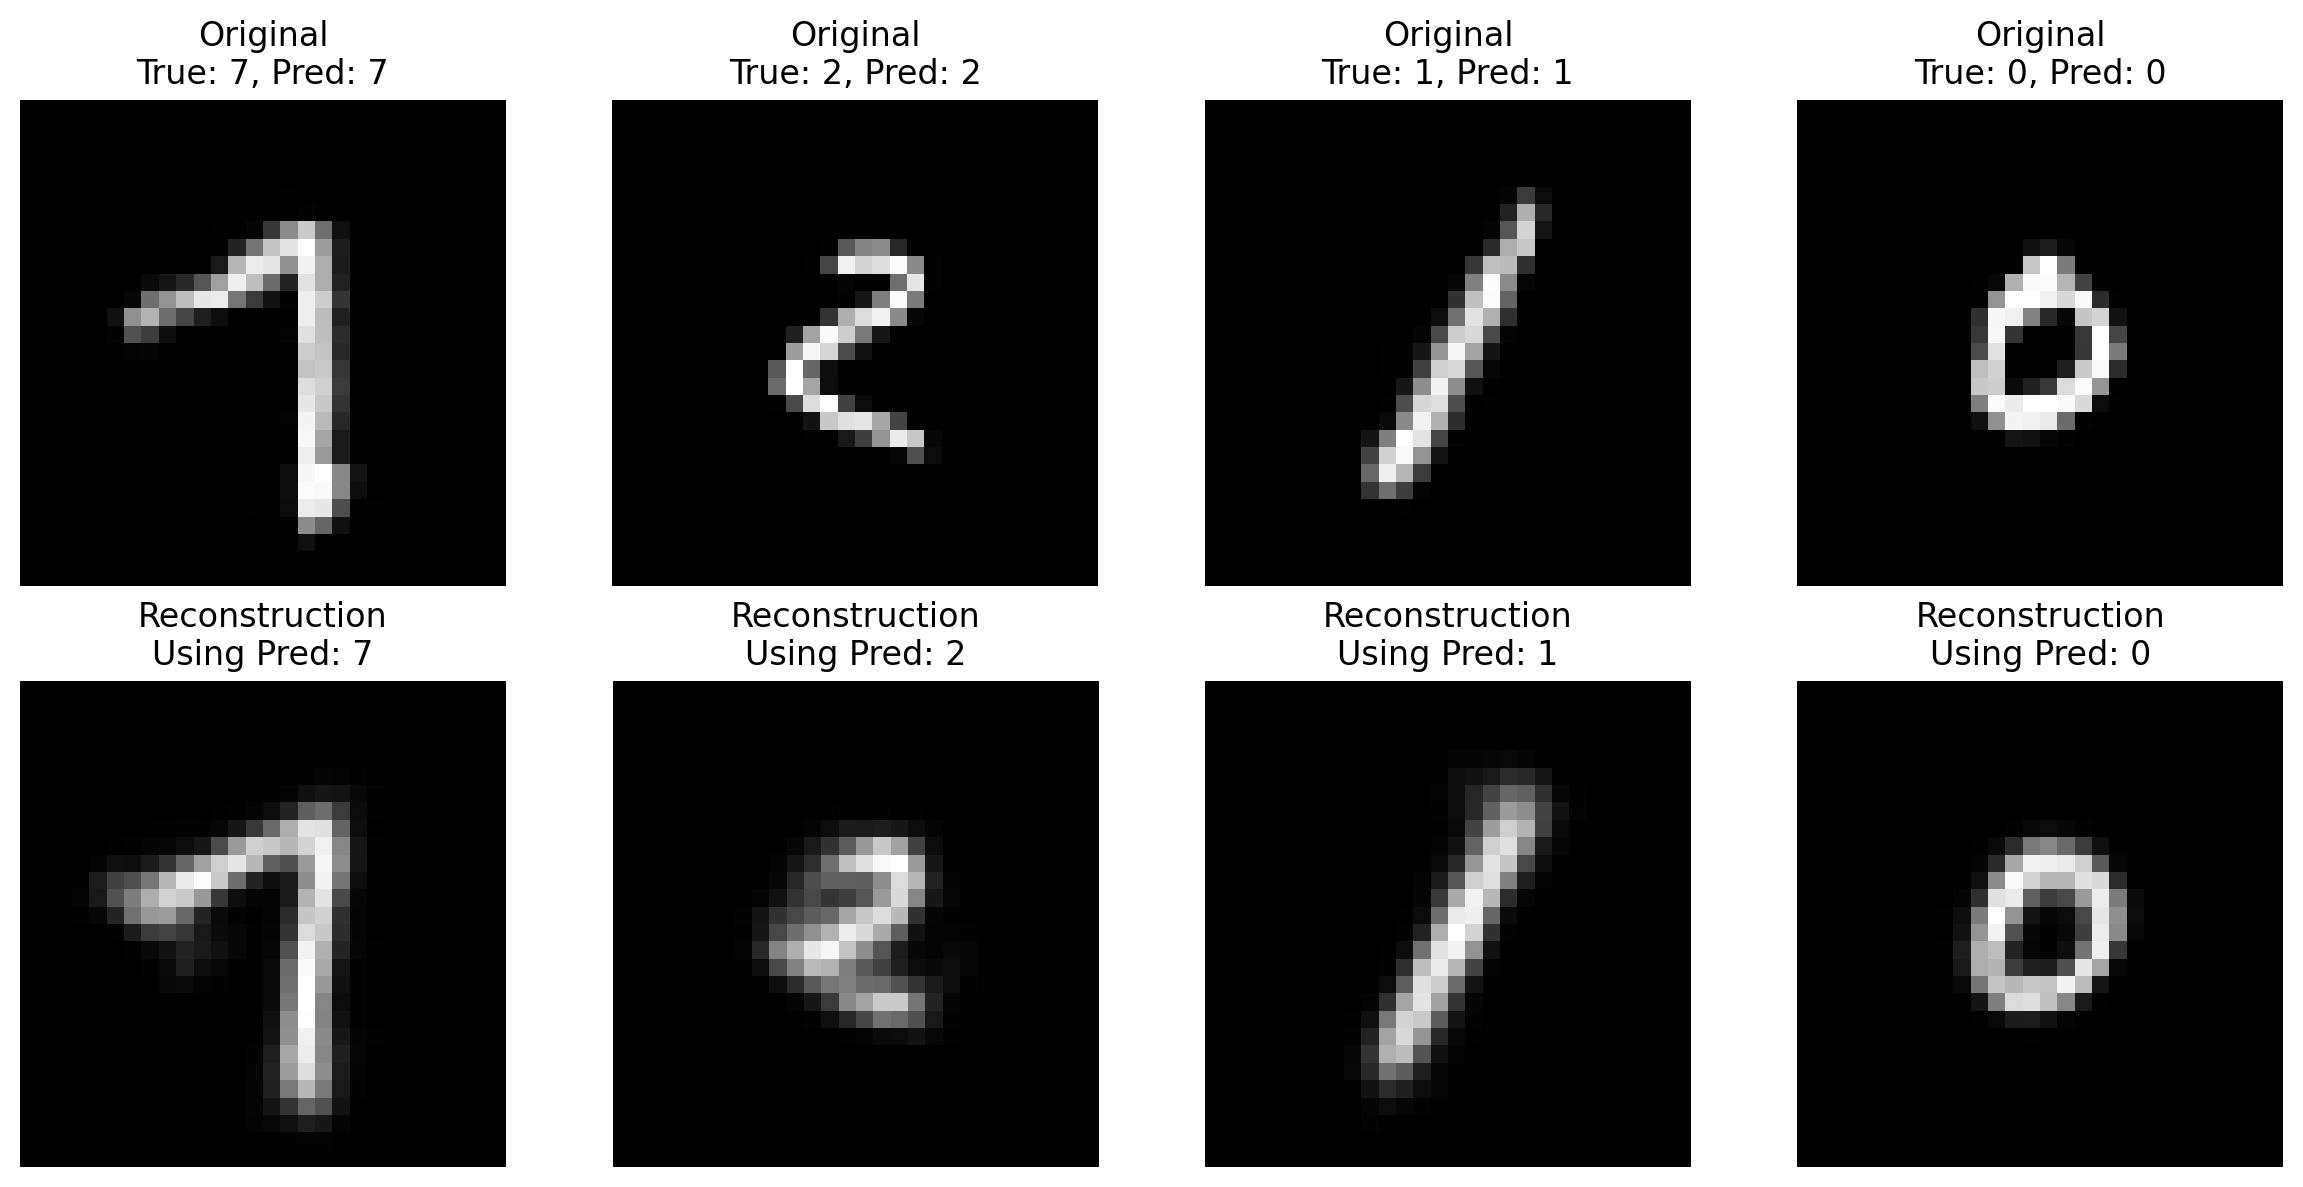

Computing conditional latent representations with classifier predictions...
Processed batch 0/79
Processed batch 10/79
Processed batch 20/79
Processed batch 30/79
Processed batch 40/79
Processed batch 50/79
Processed batch 60/79
Processed batch 70/79
Running t-SNE on conditional latent space...


/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-

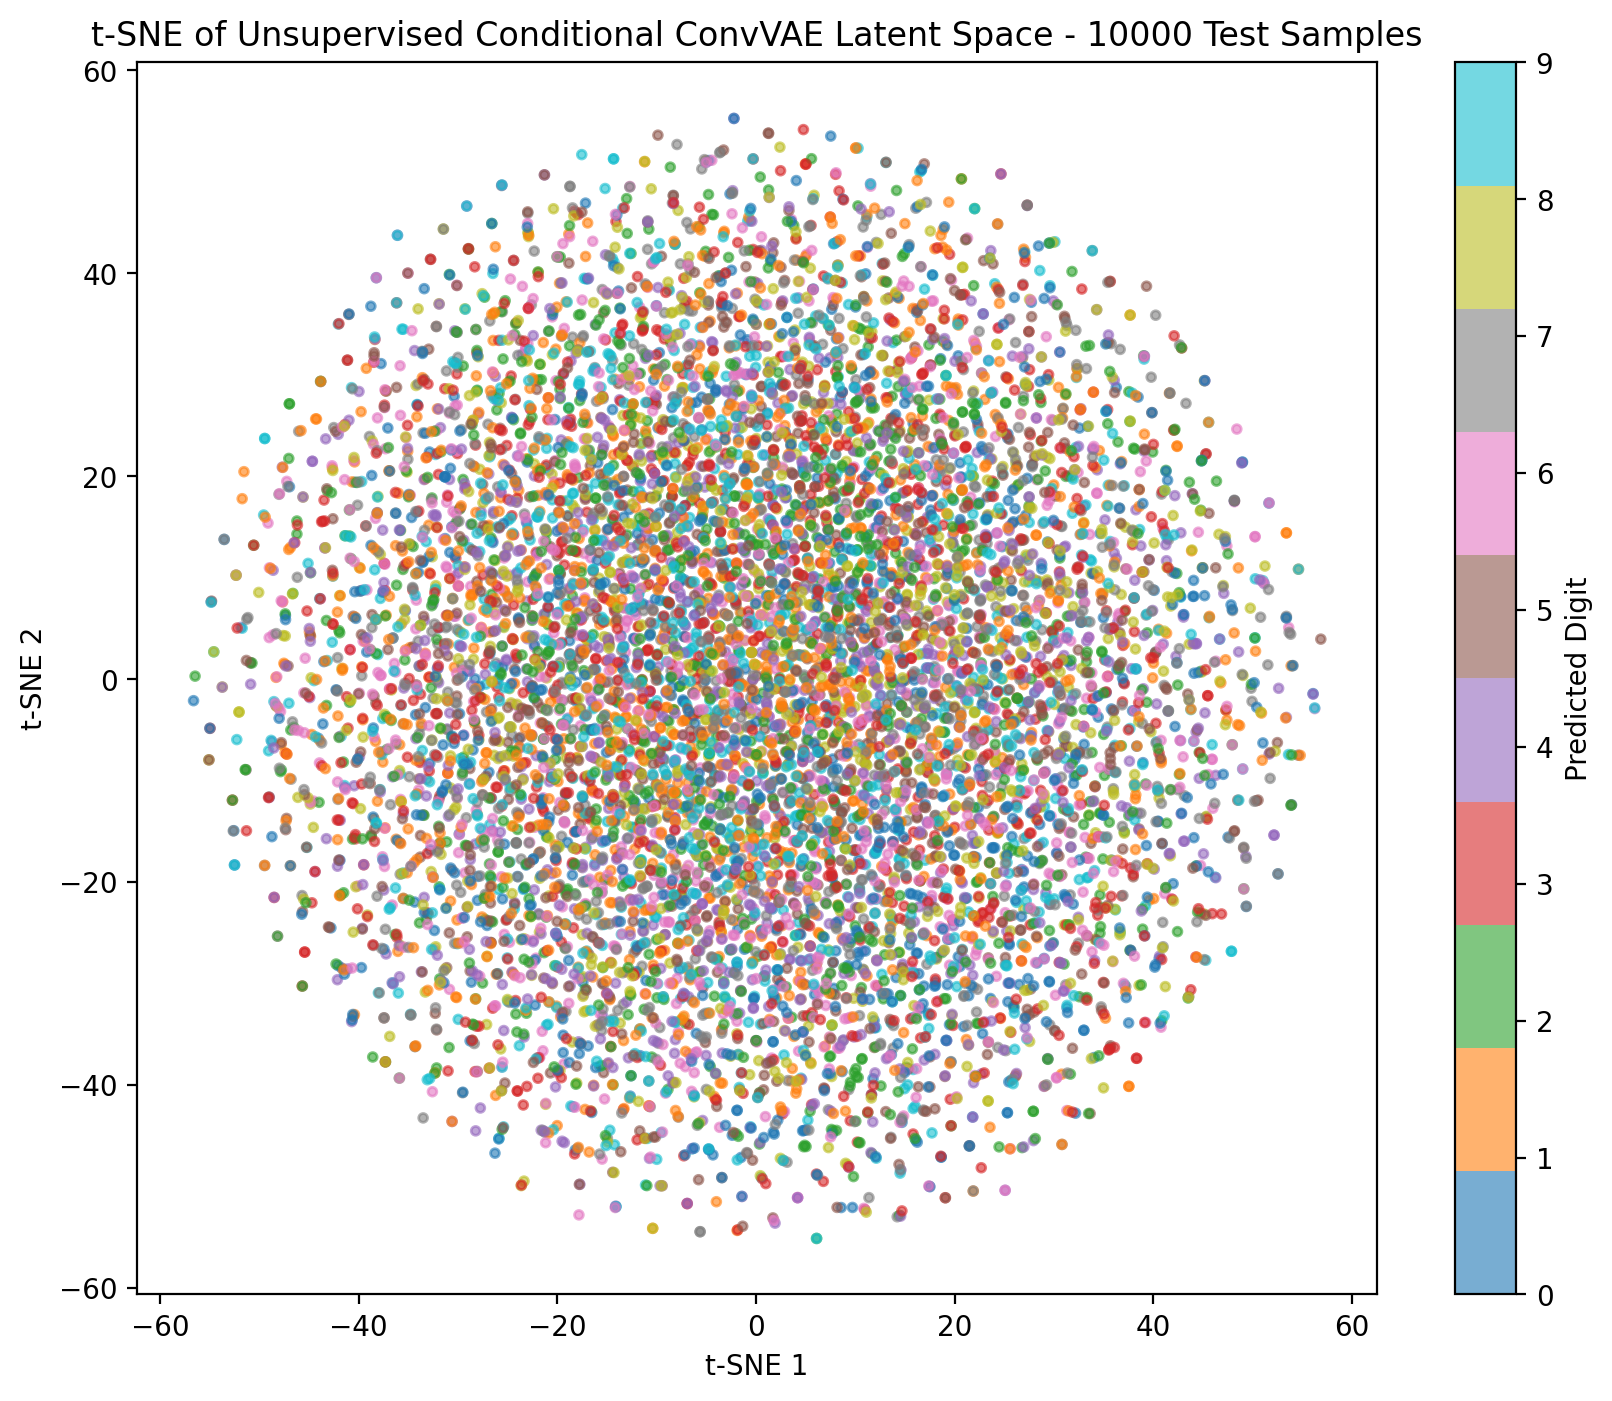


Generating samples conditioned on specific digits...


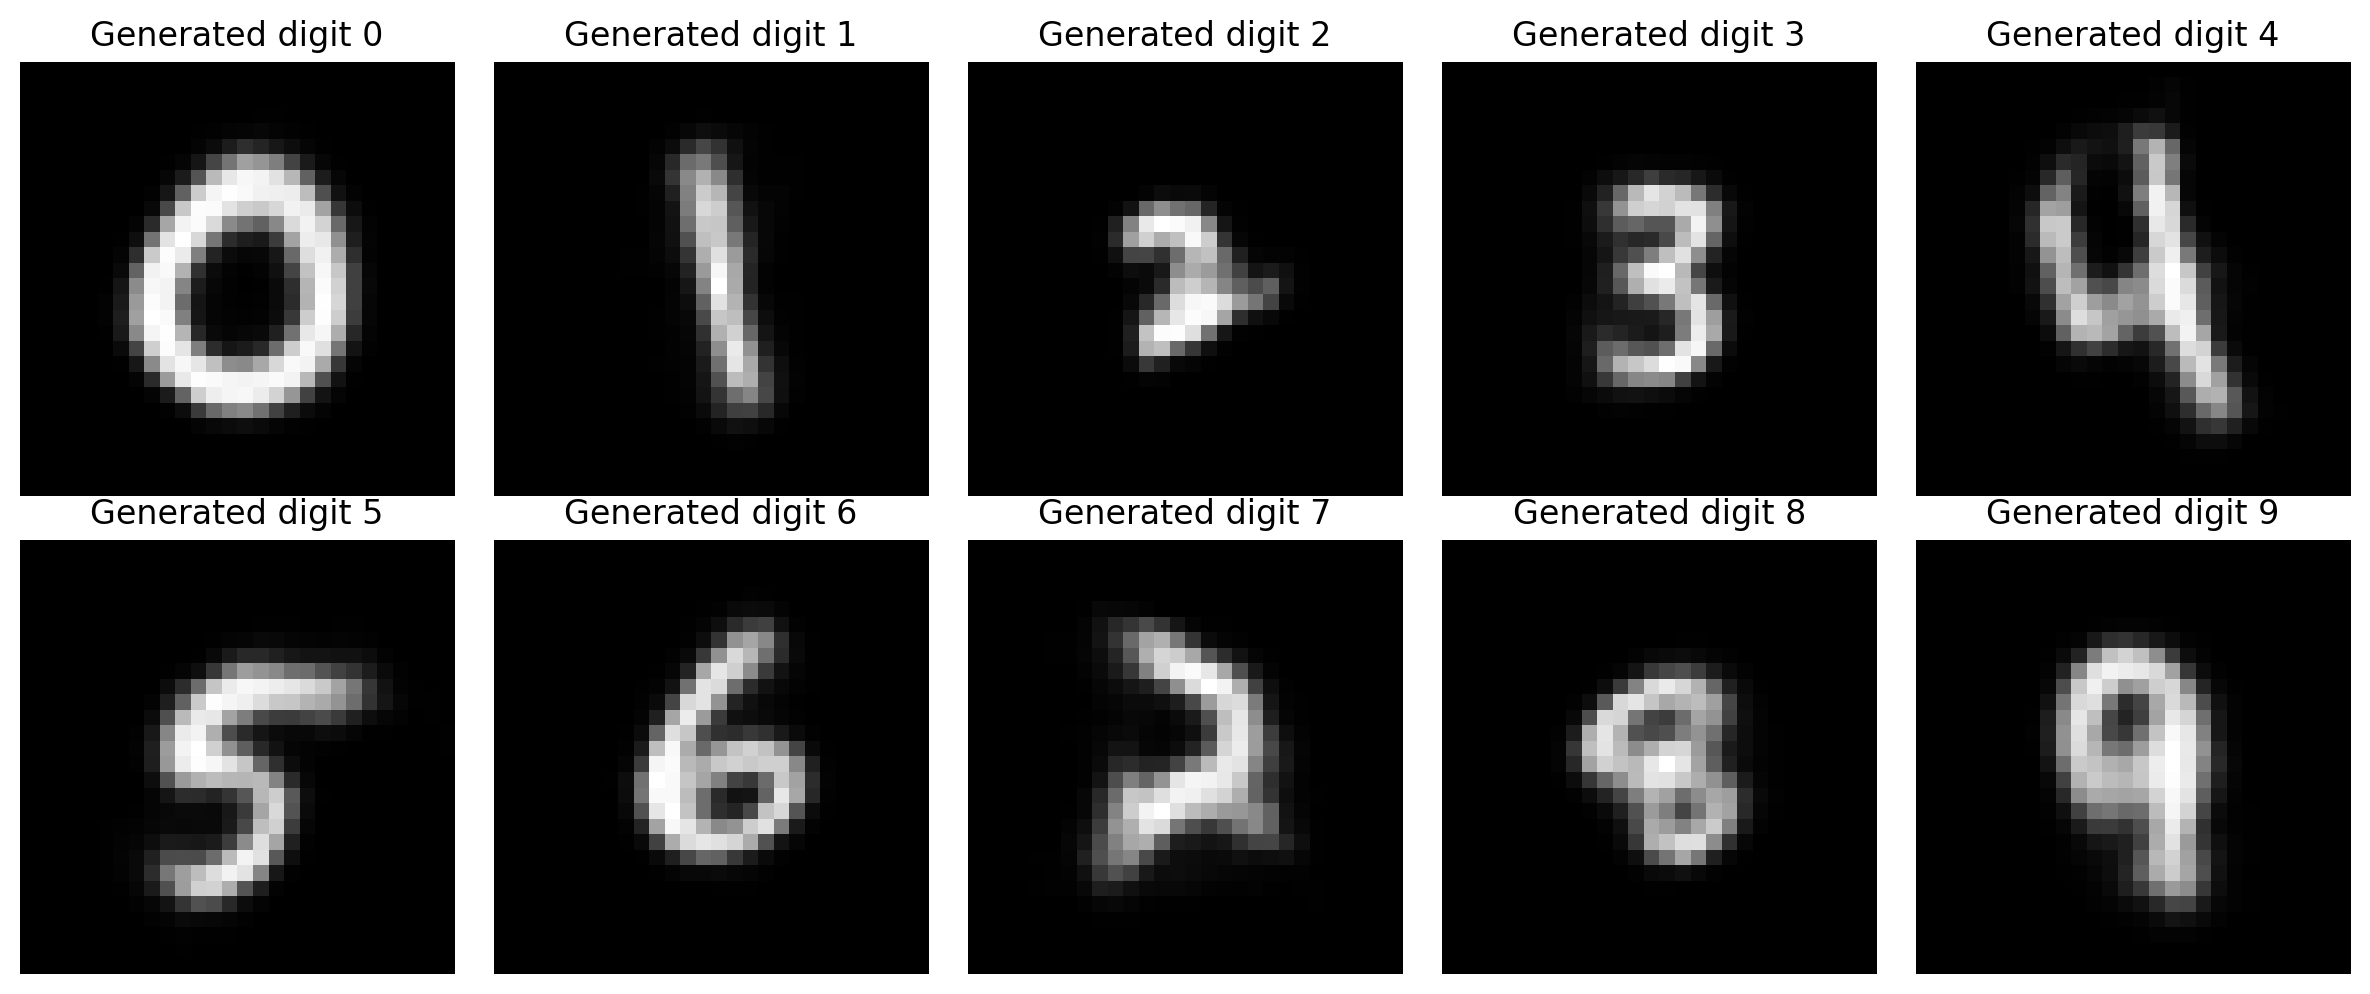

In [4]:

# Show conditional reconstructions
print("\nGenerating conditional reconstructions with classifier predictions...")
examples, labels = next(iter(test_loader))
examples = examples[:4].to(device)

# Get classifier predictions for the examples
with torch.no_grad():
    predicted_labels = classifier.predict(examples)
    y_onehot = one_hot(predicted_labels, num_classes=10).to(device)
    reconstructions, _ = cond_vae(examples, y_onehot)

examples = examples.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()
predicted_labels = predicted_labels.cpu().numpy()
true_labels = labels[:4].numpy()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(examples[i][0], cmap='gray')
    axes[0, i].set_title(f"Original\nTrue: {true_labels[i]}, Pred: {predicted_labels[i]}")
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructions[i][0], cmap='gray')
    axes[1, i].set_title(f"Reconstruction\nUsing Pred: {predicted_labels[i]}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


#import t-SNE
from sklearn.manifold import TSNE

# Visualize conditional latent space with t-SNE
print("Computing conditional latent representations with classifier predictions...")
all_z_cond = []
all_labels_cond = []

cond_vae.eval()
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)

        # Get classifier predictions instead of using true labels
        predicted_labels = classifier.predict(data)
        y_onehot = one_hot(predicted_labels, num_classes=10).to(device)

        mu, logvar = cond_vae.encode(data)
        z = cond_vae.reparameterize(mu, logvar)
        all_z_cond.append(z.cpu().numpy())
        all_labels_cond.append(predicted_labels.cpu().numpy())  # Use predicted labels
        if batch_idx % 10 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

all_z_cond = np.concatenate(all_z_cond, axis=0)
all_labels_cond = np.concatenate(all_labels_cond, axis=0)

print("Running t-SNE on conditional latent space...")
tsne_cond = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
z_2d_cond = tsne_cond.fit_transform(all_z_cond)

plt.figure(figsize=(10, 8))
plt.scatter(z_2d_cond[:, 0], z_2d_cond[:, 1], c=all_labels_cond, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(label='Predicted Digit')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(f"t-SNE of Unsupervised Conditional ConvVAE Latent Space - {len(all_z_cond)} Test Samples")
plt.show()

# Generate samples conditioned on specific digits
print("\nGenerating samples conditioned on specific digits...")
cond_vae.eval()
with torch.no_grad():
    # Sample from prior
    z_samples = torch.randn(10, latent_dims).to(device)

    # Create one-hot conditions for digits 0-9
    digit_conditions = torch.eye(10).to(device)  # 10x10 identity matrix

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i in range(10):
        row, col = i // 5, i % 5
        # Generate image for digit i
        generated = cond_vae.decode(z_samples[i:i+1], digit_conditions[i:i+1])
        axes[row, col].imshow(generated[0, 0].cpu().numpy(), cmap='gray')
        axes[row, col].set_title(f"Generated digit {i}")
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()



Exercise: Reconstruct with different predicted labels
Selected random example (index 96) with true label: 1, predicted label: 1


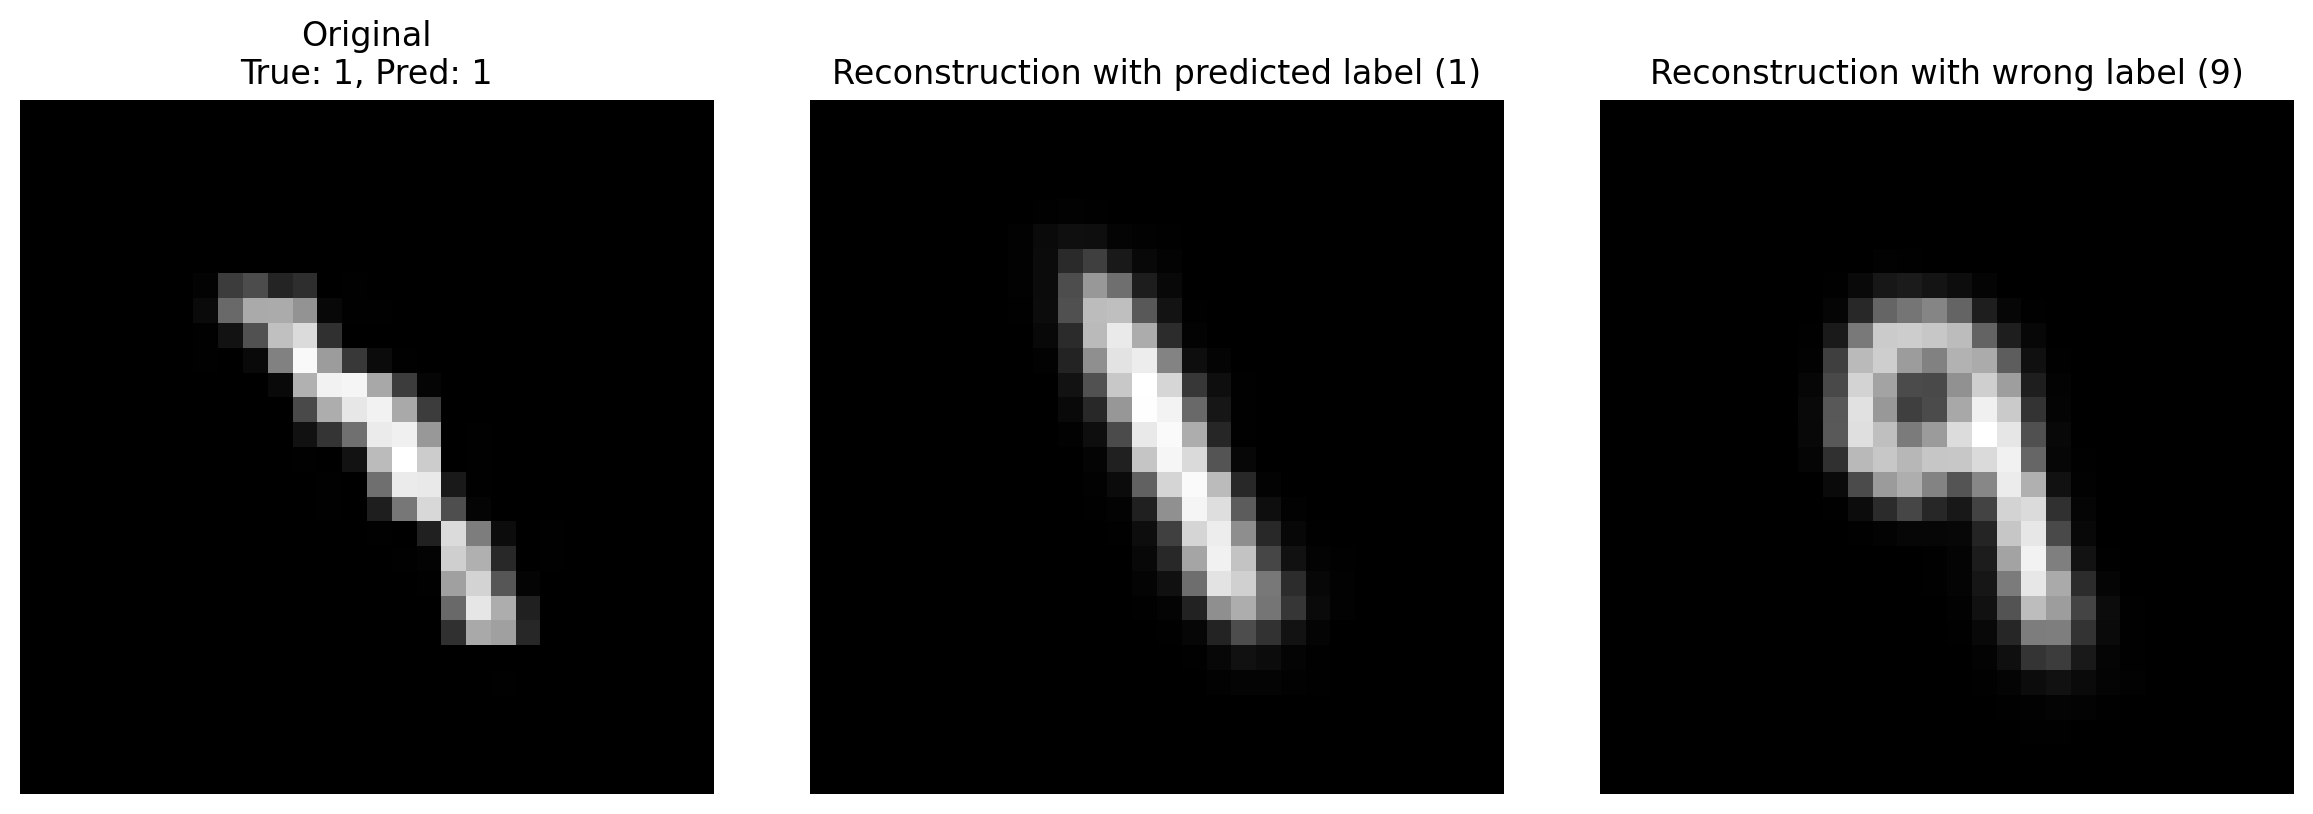

Comparison complete! Notice how the reconstruction changes when using different labels.
True label: 1, Classifier prediction: 1


In [99]:

# ====== Exercise: Reconstruct with different labels ======
print("\n" + "="*50)
print("Exercise: Reconstruct with different predicted labels")
print("="*50)

# Take a random example from test set
test_example, test_label = next(iter(test_loader))
import random
random_idx = random.randint(0, test_example.size(0)-1)  # Random index within batch
example = test_example[random_idx:random_idx+1].to(device)  # Take random example
true_label = test_label[random_idx].item()

# Get classifier prediction for this example
with torch.no_grad():
    predicted_label = classifier.predict(example).item()

print(f"Selected random example (index {random_idx}) with true label: {true_label}, predicted label: {predicted_label}")

# Extract latent representation
cond_vae.eval()
with torch.no_grad():
    # Encode to get latent z
    mu, logvar = cond_vae.encode(example)
    z = cond_vae.reparameterize(mu, logvar)

    # 1) Reconstruct with predicted label
    predicted_condition = one_hot(torch.tensor([predicted_label]), num_classes=10).to(device)
    reconstruction_predicted = cond_vae.decode(z, predicted_condition)

    # 2) Reconstruct with label '9'
    wrong_condition = one_hot(torch.tensor([9]), num_classes=10).to(device)
    reconstruction_wrong = cond_vae.decode(z, wrong_condition)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original
axes[0].imshow(example[0, 0].cpu().numpy(), cmap='gray')
axes[0].set_title(f"Original\nTrue: {true_label}, Pred: {predicted_label}")
axes[0].axis('off')

# Reconstruction with predicted label
axes[1].imshow(reconstruction_predicted[0, 0].cpu().numpy(), cmap='gray')
axes[1].set_title(f"Reconstruction with predicted label ({predicted_label})")
axes[1].axis('off')

# Reconstruction with wrong label
axes[2].imshow(reconstruction_wrong[0, 0].cpu().numpy(), cmap='gray')
axes[2].set_title(f"Reconstruction with wrong label (9)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Comparison complete! Notice how the reconstruction changes when using different labels.")
print(f"True label: {true_label}, Classifier prediction: {predicted_label}")
